In [1]:
using IndexedGraphs, SparseArrays, MatrixProductBP, Random, Plots, Statistics
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

# OBC

## MonteCarlo

In [13]:
include("wolff.jl");

In [148]:
N = 12
T = N - 1
T1 = T + 1
d = (N, T1)
β = 1.0
J0 = 1.0
h0 = 1e-1

# h = sparse([fill(h0, prod(d)÷2); fill(-h0, prod(d)÷2)])
h = sparse(h0*randn(prod(d)))
# h = sparse(fill(h0, prod(d)))
# h = (1:N*T1) ./ (N*T1)
J = J0 * lattice(d, (true, true))

# delete bonds between spins (N,2N), (2N,3N) and so on, because they correspond to interaction xᵢ^ᵀ,xⱼ^ᵀ in
#  the dynamical model, which are not supported
bonds_to_delete = [(N*(T1-1)+i,N*(T1-1)+i+1) for i in 1:N-1]
for b in bonds_to_delete
   J[b...] = J[reverse(b)...] = 0 
end
dropzeros!(J);

In [149]:
ntherm = 10^4
nsamples = 10^6

stats = Stats(N*T1)

wolff(β*J, β*h, nsamples, stats; ntherm);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


In [159]:
m_mc = magnetizations(stats)
c_mc_full = correlations(stats)
ci = CartesianIndices(c_mc_full)
li = LinearIndices(zeros(N, T1))
c_mc = map(edges(bp.g)) do e
   i, j = e
   map(1:T) do t
        c_mc_full[li[i,t], li[j,t]]
    end
end;

In [150]:
# scatter(magnetization(stats)[1:1000:end], xlabel="iter", ylabel="total magnetiz", label="",
#     ms=2, c=:black, msc=:auto)

In [151]:
# @show mean(m_mc)
# heatmap(reshape(m_mc, N, T1), clims=(-1,1), xlabel="t", ylabel="i", yflip=true)

## MPBP

In [152]:
struct Ising2DOpen{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
    border :: Bool
end

spin(x, i = 0) = 3-2x

function (f::Ising2DOpen)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + (f.border ? 0 : f.βJh*spin(xₙᵢᵗ[1])) )
    exp(h)
end

In [153]:
βJ = β * J0
# T = N - 1
G = IndexedBiDiGraph(chain(N, true))
h_matrix = reshape(h, N, T1)

w = [[Ising2DOpen(βJ, βJ, i==1) for t=0:T] for i=1:N]
ϕ = [[[exp(β*h_matrix[i,t]), exp(-β*h_matrix[i,t])] for t in 1:T+1] for i in 1:N]
bp = mpbp(G, w, fill(2,N), T; ϕ);

In [154]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp; f=spin);

In [155]:
svd_trunc = TruncBondThresh(8, 1e-8)
iters, cb = iterate!(bp, maxiter=80; svd_trunc, cb, tol=1e-5, damp=0.2);

Running MPBP: iter 10 	 Time: 0:00:01
  Δ:                  0.0
  SVD tolerance, m':  1.0e-8, 8

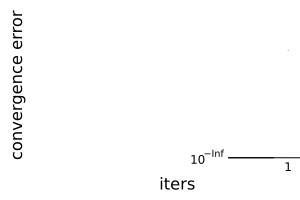

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 10 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/esM5q/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 10 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/esM5q/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: I

In [156]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [157]:
# plot(histogram(m_mc, nbins=8), histogram(reduce(vcat, means(spin, bp)), nbins=8))

In [161]:
m_bp = permutedims(reduce(hcat, means(spin, bp)))[:]
c_bp = map(pair_beliefs(bp)[1]) do pij
    [expectation(spin, pijt) for pijt in pij[1:end-1]]
end;

Pearson, magnetizations r=0.9964883920701156
Pearson, correlations r=0.9998597908255696


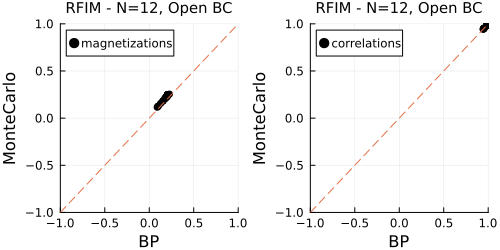

In [162]:
p1 = scatter(m_bp, m_mc, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="magnetizations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(permutedims(reduce(hcat, means(spin, bp)))[:], m_mc)
println("Pearson, magnetizations r=$r")
plot!(title="RFIM - N=$N, Open BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

p2 = scatter(reduce(vcat, c_bp), reduce(vcat, c_mc), xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="correlations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(reduce(vcat, c_bp), reduce(vcat, c_mc))
println("Pearson, correlations r=$r")
plot!(title="RFIM - N=$N, Open BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

plot(p1, p2, size=(500,250))

# OBC in 1 direction

## MonteCarlo

In [75]:
N = 30
T = N-1
T1 = T + 1
d = (N, T1)
β = 0.5
J0 = 1.0
h0 = 1e-1

# h = sparse([fill(h0, prod(d)÷2); fill(-h0, prod(d)÷2)])
# h = sparse(h0*randn(prod(d)))
# h = sparse(fill(h0, prod(d)))
# h = (1:N*T1) ./ (N*T1) .- 0.5

hh = h0*randn(T1)
h = reduce(hcat, fill(hh, N))'[:]

J = J0 * lattice(d, (false, true))

# delete bonds between spins (N,2N), (2N,3N) and so on, because they correspond to interaction xᵢ^ᵀ,xⱼ^ᵀ in
#  the dynamical model, which are not supported
bonds_to_delete = [(N*(T1-1)+i,N*(T1-1)+mod(i,N)+1) for i in 1:N]
for b in bonds_to_delete
   J[b...] = J[reverse(b)...] = 0 
end
dropzeros!(J);

In [76]:
ntherm = 10^4
nsamples = 10^5

stats = Stats(N*T1)

wolff(β*J, β*h, nsamples, stats; ntherm)
m_mc = magnetizations(stats);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


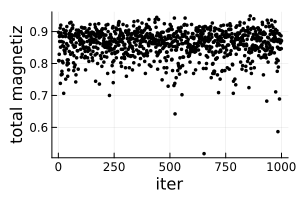

In [78]:
scatter(magnetization(stats)[1:100:end], xlabel="iter", ylabel="total magnetiz", label="",
    ms=2, c=:black, msc=:auto, size=(300,200))

## MPBP

In [27]:
struct Ising2DPeriodic{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
    border :: Bool
end

spin(x, i = 0) = 3-2x

function (f::Ising2DPeriodic)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + f.βJh*spin(xₙᵢᵗ[f.border ? 2 : 1]) )
    exp(h)
end

In [28]:
βJ = β * J0
# T = N - 1
G = IndexedBiDiGraph(chain(N, false))
h_matrix = reshape(h, N, T1)

w = [[Ising2DPeriodic(βJ, βJ, i == N || i == 1) for t=0:T] for i=1:N]
ϕ = [[[exp(β*h_matrix[i,t]), exp(-β*h_matrix[i,t])] for t in 1:T+1] for i in 1:N]
bp = mpbp(G, w, fill(2,N), T; ϕ);

In [29]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp; f=spin);

In [30]:
svd_trunc = TruncBondThresh(8, 1e-8)
maxiter = 100
iters, cb = iterate!(bp; maxiter, svd_trunc, cb, tol=1e-4, damp=0.2)
iters == maxiter && @warn "BP did not converge";

Running MPBP: iter 61 	 Time: 0:17:06
  Δ:                  8.767176362084461e-5
  SVD tolerance, m':  1.0e-8, 8

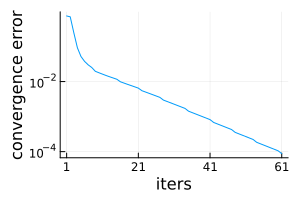

In [31]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

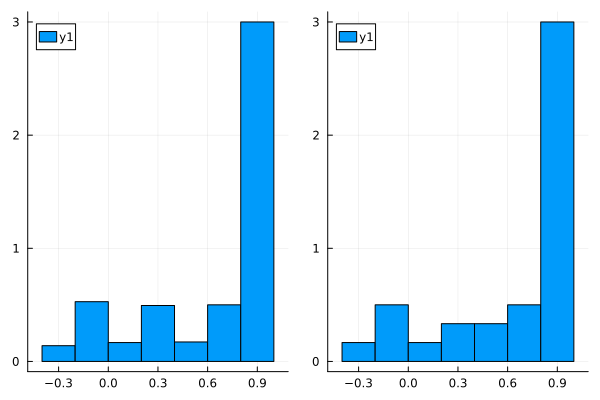

In [32]:
plot( histogram(m_mc, nbins=8, normalize=true), 
      histogram(reduce(vcat, means(spin, bp)), nbins=8, normalize=true) )
# heatmap(abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N)))
# abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N))

r = 0.9993868164540191


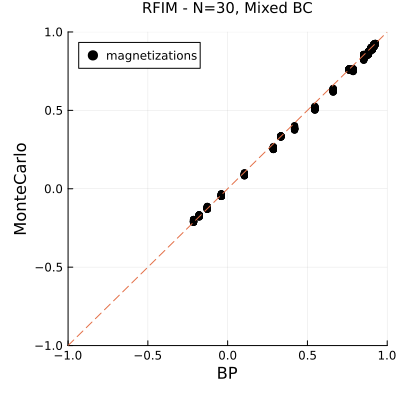

In [33]:
scatter(permutedims(reduce(hcat, means(spin, bp)))[:], m_mc, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="magnetizations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(permutedims(reduce(hcat, means(spin, bp)))[:], m_mc)
@show r
plot!(title="RFIM - N=$N, Mixed BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

## MPBP infinite

In [79]:
struct Ising2DInfinite{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
end

spin(x, i = 0) = 3-2x

function (f::Ising2DInfinite)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + 0.5*f.βJh*sum(spin, xₙᵢᵗ) )
    exp(h)
end

In [111]:
G = IndexedBiDiGraph(chain(N, false))
h_matrix = reshape(h, N, T1)

wᵢ = [Ising2DInfinite(β*J0, β*J0) for _ in 1:T+1]
ϕᵢ = [[exp(β*ht), exp(-β*ht)] for ht in hh]

bp_inf = mpbp_infinite_graph(2, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp_inf; f=spin, showprogress=false);

In [112]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp_inf; f=spin);

In [113]:
svd_trunc = TruncBondThresh(2, 1e-8)
maxiter = 100
iters, cb = iterate!(bp_inf; maxiter, svd_trunc, cb, tol=1e-5, damp=0.2)
iters == maxiter && @warn "BP did not converge";

Running MPBP: iter 33 	 Time: 0:00:02
  Δ:                  9.601636846601203e-6
  SVD tolerance, m':  1.0e-8, 2

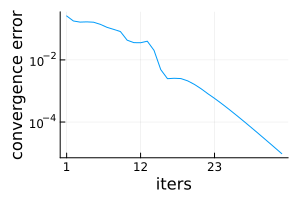

In [114]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

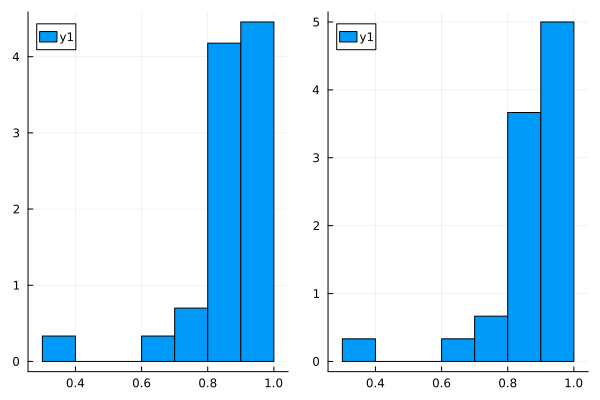

In [115]:
plot( histogram(m_mc, nbins=10, normalize=true), 
      histogram(reduce(vcat, means(spin, bp_inf)), nbins=10, normalize=true) )
# heatmap(abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N)))
# abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N))

r = 0.9998627965597418


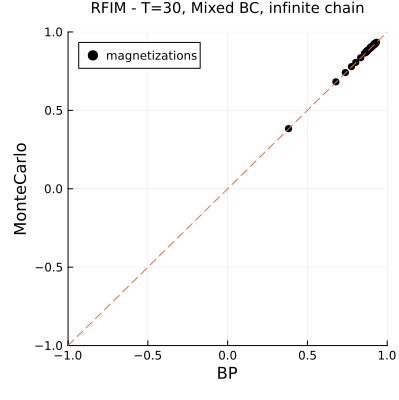

In [116]:
scatter(mean(eachrow(reshape(m_mc, N, T1))), only(means(spin, bp_inf)), xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="magnetizations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(mean(eachrow(reshape(m_mc, N, T1))), only(means(spin, bp_inf)))
@show r
plot!(title="RFIM - T=$N, Mixed BC, infinite chain", size=(400,400), 
    titlefontsize=10, xlims=lims, ylims=lims)

In [118]:
mean(mean(eachrow(reshape(m_mc, N, T1)))), mean(only(means(spin, bp_inf)))

(0.862338088888889, 0.8654801234928821)